In [1]:
from ptm import deepPTM

import pandas as pd
import cloudpickle
import numpy as np

import ray

import networkx as nx
from ns.topos.fattree import build as build_fattree

from inference import Device

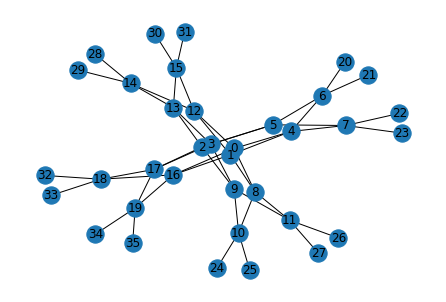

In [2]:
G = build_fattree(4)
nx.draw(G, with_labels=True)

In [3]:
df = pd.read_csv('../data/rsim.csv')

with open('../data/rsim.flow_to_port', 'rb') as f:
    flow_to_port = cloudpickle.load(f)
with open('../data/rsim.port_to_nexthop', 'rb') as f:
    port_to_nexthop = cloudpickle.load(f)

In [7]:
# Get initial devices, and setup the initial packets to simulate.
initial_devices = pd.unique(df['cur_hub'].loc[df['path'].apply(lambda x: "-" not in x)])
all_devices = pd.unique(df['cur_hub']) # This assumes that the devices are 0, ..., N
devices = [None] * len(all_devices)
for d in all_devices:
    if d in initial_devices:
        devices[d] = Device.remote(d, df.loc[df['cur_hub'] == d])
    else:
        devices[d] = Device.remote(d, pd.DataFrame(columns=df.columns))

In [8]:
step = 0
model = None # TODO: Load the model here
while True:
    step += 1
    potential_updates = [dev.forward_block.remote(None, port_to_nexthop, flow_to_port) for dev in devices]
    all_updates = [[] for _ in range(len(devices))]
    made_update = False
    for d, potential_update in enumerate(potential_updates):
        new_device_time, forward_dict = ray.get(potential_update)
        # If there are packets to forward and the timestamp is not the places we are sending the packets to have timestamps of a certain kind.
        condition = forward_dict != {} # and ... TODO ...?
        if condition:
            made_update = True
            devices[d].update_time.remote(new_device_time)
            for forward_device, new_packets in forward_dict.items():
                all_updates[forward_device].append(new_packets)

    # Add the new packets to the respective devices.
    ray.get([devices[d].add_new_packets.remote(update) for d, update in enumerate(all_updates)])

    if not made_update:
        break

# Now we can get the final dataframe simply by extracting the dataframes, concatentating, and re-sorting on timestamp.
final_df = pd.concat(ray.get([dev.get_df.remote() for dev in devices])).sort_values('timestamp')

In [9]:
# Now, let's make sure that both our df and the original df have the same number of rows
print(len(final_df), len(df)) # ?

395535 648086
